## **Heart Disease Prediction**

### Importing and Transforming Dataset

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from pylab import rcParams

In [196]:
%matplotlib inline
rcParams['figure.figsize'] = 5,3
rcParams["legend.fontsize"] = 8

warnings.filterwarnings("ignore")

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease">Personal Key Indicators</a> in Kaggle, which contains various risk factors and important markers related to heart disease, such as high BMI (obesity), diabetes, smoking, and alcohol consumption.

In [197]:
heart_disease_df = pd.read_csv('./dataset/Key Indicators of Heart Disease.csv')
heart_disease_df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [198]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

Check if there are missing values

In [199]:
heart_disease_df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

### Checking If Target Variable is Binary

The target variable is the `HeartDisease` column, which should have only two distinct values, namely `Yes` and `No`.

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

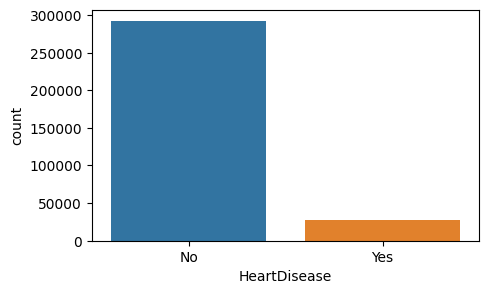

In [200]:
sb.countplot(x='HeartDisease', data=heart_disease_df)

The chart reveals that there is an imbalance in the number of records for `HeartDisease`, indicating an uneven distribution of data between individuals who have the ailment and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. To balance the class distribution, we will use SMOTE (Synthetic Minority Oversampling Technique). However, before using SMOTE, all categorical data must be transformed into binary using dummy variables for the method to function effectively.

The <b>SMOTE</b> algorithm takes in the closest minority class data entries and creates new combinations based on those entries.<sup>2</sup>


### Exploratory Analysis on Feature Variables

View summary statistics of `BMI`

In [201]:
heart_disease_df.groupby('HeartDisease').describe()

BMI                                                   \
                 count       mean       std    min    25%    50%    75%   
HeartDisease                                                              
No            292422.0  28.224658  6.325660  12.02  23.89  27.26  31.32   
Yes            27373.0  29.401592  6.577151  12.21  25.06  28.34  32.69   

                    PhysicalHealth            ... MentalHealth        \
                max          count      mean  ...          75%   max   
HeartDisease                                  ...                      
No            94.85       292422.0  2.956416  ...          3.0  30.0   
Yes           83.33        27373.0  7.808242  ...          4.0  30.0   

             SleepTime                                                
                 count      mean       std  min  25%  50%  75%   max  
HeartDisease                                                          
No            292422.0  7.093416  1.399331  1.0  6.0  7.0  8.0  24.0  
Yes            27373.0  7.136156  1.780863  1.0  6.0  7.0  8.0  24.0  

[2 rows x 32 columns]

Data distribution of cases with Yes/No heart disease according to `Race`

<AxesSubplot: xlabel='Race', ylabel='count'>

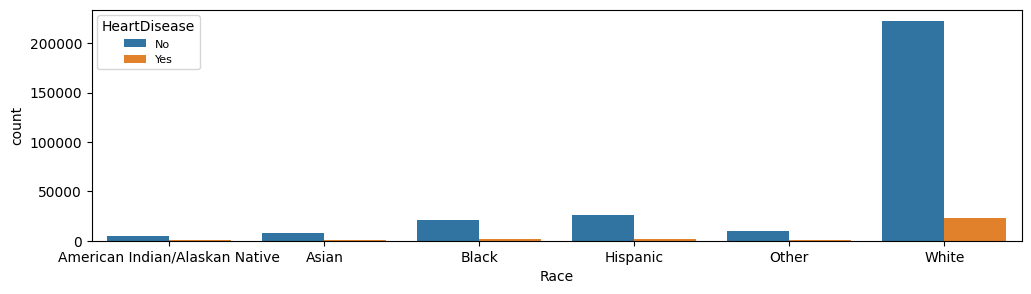

In [202]:
plt.figure(figsize = (12,3))
sb.countplot(x=heart_disease_df['Race'].sort_values(ascending=True), hue='HeartDisease', data=heart_disease_df)

Considering a person's race is important in heart disease prediction as different racial and ethnic groups can have different genetic predispositions and social determinants of health that influence disease risk and outcomes. Hence, we will only consider the `White` group since it has the largest size of records. Drop the `Race` feature afterwards.

In [203]:
heart_disease_df_filtered = heart_disease_df[heart_disease_df['Race'] == 'White']
heart_disease_df_filtered = heart_disease_df_filtered.reset_index(drop=True)
heart_disease_df_filtered['Race'].unique()

array(['White'], dtype=object)

In [204]:
# Drop the `Race` feature
heart_disease_df_filtered = heart_disease_df_filtered.drop(columns=['Race'], axis=1)
heart_disease_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245212 entries, 0 to 245211
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      245212 non-null  object 
 1   BMI               245212 non-null  float64
 2   Smoking           245212 non-null  object 
 3   AlcoholDrinking   245212 non-null  object 
 4   Stroke            245212 non-null  object 
 5   PhysicalHealth    245212 non-null  float64
 6   MentalHealth      245212 non-null  float64
 7   DiffWalking       245212 non-null  object 
 8   Sex               245212 non-null  object 
 9   AgeCategory       245212 non-null  object 
 10  Diabetic          245212 non-null  object 
 11  PhysicalActivity  245212 non-null  object 
 12  GenHealth         245212 non-null  object 
 13  SleepTime         245212 non-null  float64
 14  Asthma            245212 non-null  object 
 15  KidneyDisease     245212 non-null  object 
 16  SkinCancer        24

Get all categorical features

In [205]:
categorical_columns = [name for name in heart_disease_df_filtered.columns if heart_disease_df_filtered[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 13 categorical features:

HeartDisease, Smoking, AlcoholDrinking, Stroke, DiffWalking, Sex, AgeCategory, Diabetic, PhysicalActivity, GenHealth, Asthma, KidneyDisease, SkinCancer


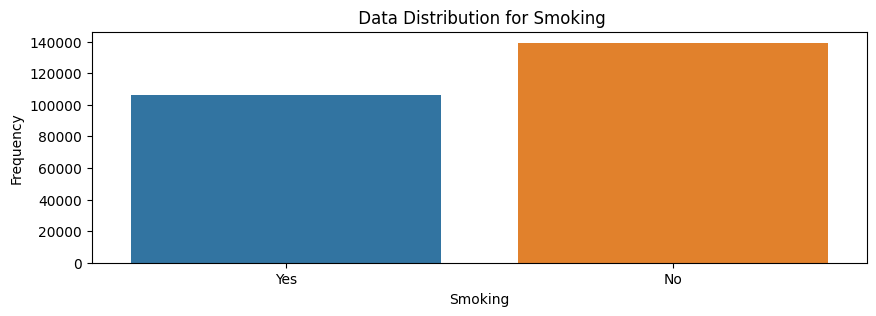

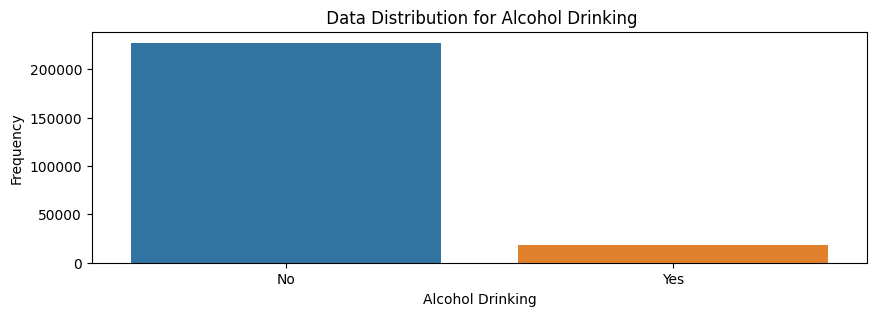

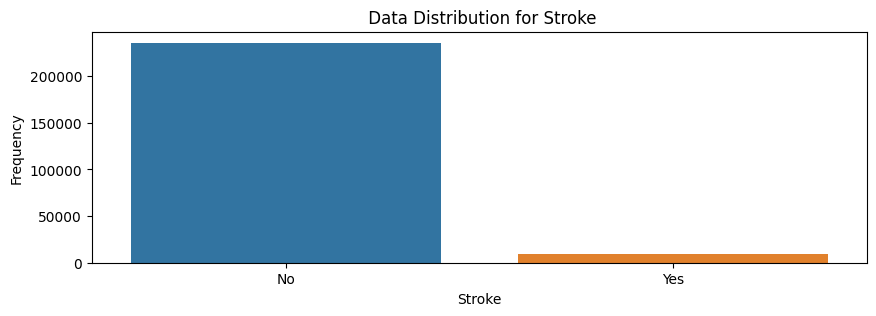

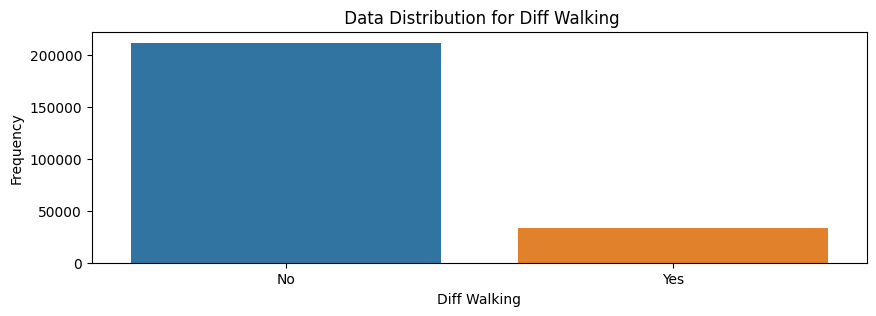

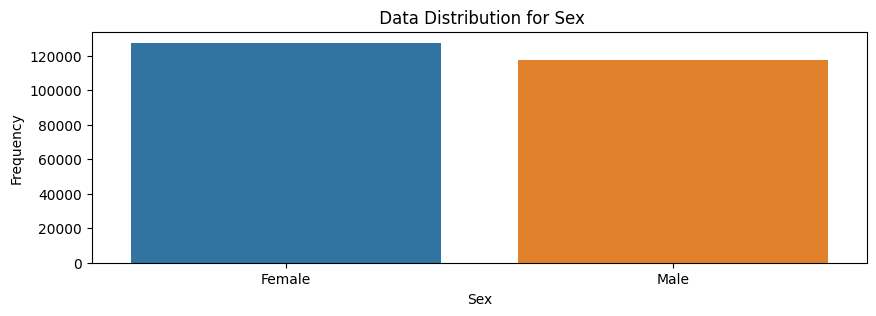

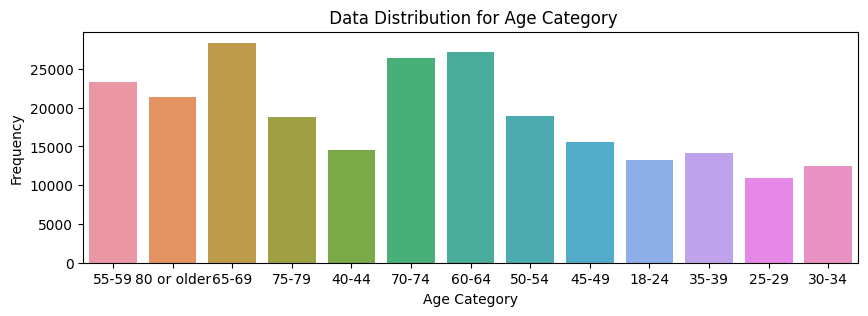

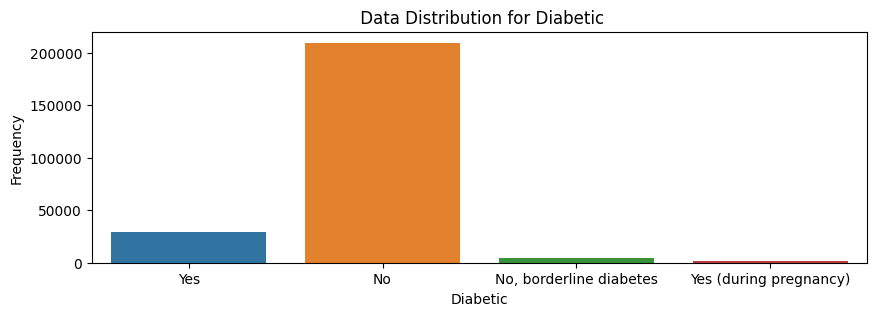

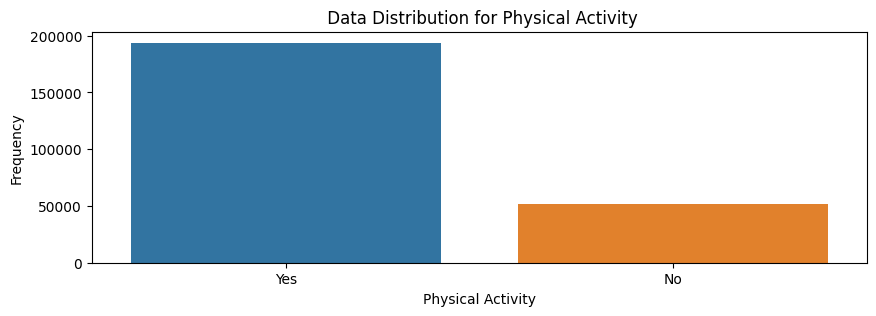

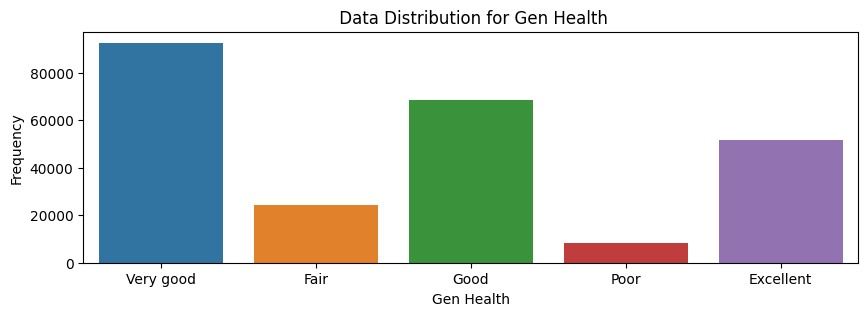

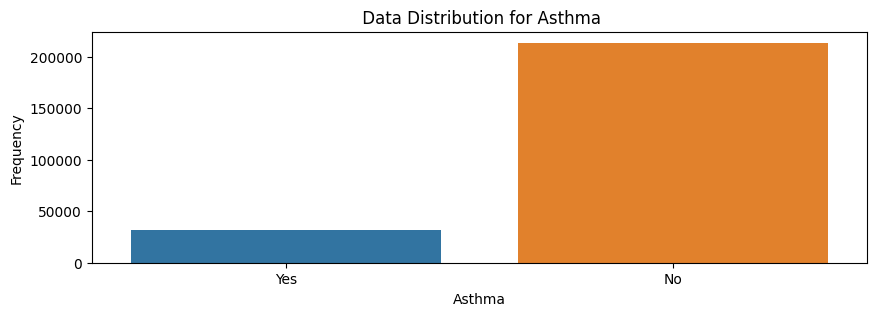

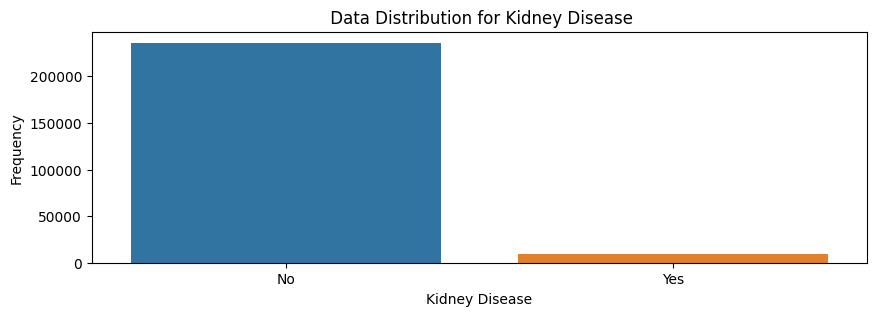

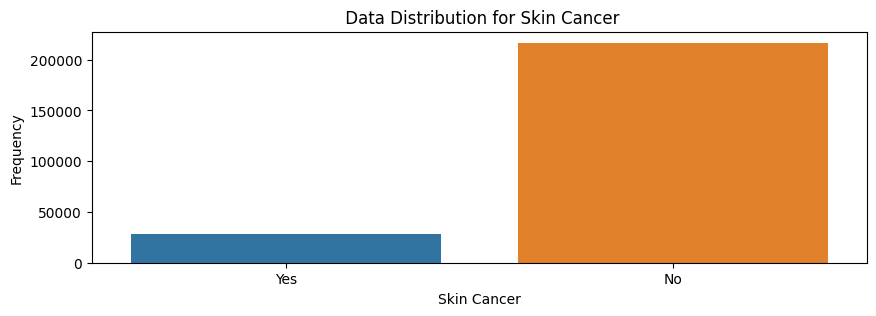

In [206]:
def getFeatureLabelName(feature):
    label_name = ""
    for idx, char in enumerate(feature):
        if idx != 0 and char.isupper():
            label_name = label_name + " " + char
        else:
            label_name = label_name + char
    return label_name


features = heart_disease_df_filtered[categorical_columns].columns

for idx, feature in enumerate(features):
    if feature in ['HeartDisease', 'Race']:
        continue
    
    label_name = getFeatureLabelName(feature)
    
    plt.figure(figsize=(10,3))
    sb.countplot(data=heart_disease_df_filtered, x=feature)
    plt.xlabel(label_name)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution for " + label_name)
    
plt.show()

### Converting Categorical Features to Dummy Indicators

Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [207]:
feature_no_drop = ['AgeCategory', 'Diabetic', 'GenHealth']

categorical_drop_first = [name for name in categorical_columns if name not in feature_no_drop]
categorical_no_drop = [name for name in categorical_columns if name in feature_no_drop]

heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_filtered, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head(5)

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,AgeCategory_80 or older,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,3.0,30.0,5.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,20.34,0.0,0.0,7.0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
2,26.58,20.0,30.0,8.0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,24.21,0.0,0.0,6.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,23.71,28.0,0.0,8.0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


After the conversion, the target features have expanded from the original 17 columns to a total of 36 columns.

In [208]:
heart_disease_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245212 entries, 0 to 245211
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   BMI                               245212 non-null  float64
 1   PhysicalHealth                    245212 non-null  float64
 2   MentalHealth                      245212 non-null  float64
 3   SleepTime                         245212 non-null  float64
 4   HeartDisease_Yes                  245212 non-null  uint8  
 5   Smoking_Yes                       245212 non-null  uint8  
 6   AlcoholDrinking_Yes               245212 non-null  uint8  
 7   Stroke_Yes                        245212 non-null  uint8  
 8   DiffWalking_Yes                   245212 non-null  uint8  
 9   Sex_Male                          245212 non-null  uint8  
 10  PhysicalActivity_Yes              245212 non-null  uint8  
 11  Asthma_Yes                        245212 non-null  u

### Finding Optimal Value for k-Nearest Neighbors

Determine the optimal k value to be utilized for SMOTE's k-nearest neighbors during the creation of synthetic samples.

In [209]:
X_features = heart_disease_df_dummy.drop(['HeartDisease_Yes'], axis=1)
y_target = heart_disease_df_dummy['HeartDisease_Yes']

param_grid = {'n_neighbors': [55, 60]}

# Create a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# Use grid search to find the optimal value of k
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_features, y_target)

# Print the best parameter and score
best_param = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameter: {best_param}")
print(f"Best score: {round(best_score, 2)}")

Best parameter: {'n_neighbors': 60}
Best score: 0.91


### Creating Synthetic Data using SMOTE

Synthetic data will be generated using SMOTE, as previously stated, to achieve a balanced distribution of data across all classes. The value of `k_neighbors` to be used will be 60, which provided the highest score during the hyperparameter tuning process for k-nearest neighbors.

In [210]:
oversample = SMOTE(k_neighbors=best_param['n_neighbors'], random_state=42)
print(f"{oversample}")

SMOTE(k_neighbors=60, random_state=42)


The original count of 22,507 records for the 'with Heart Disease' class has now been balanced with the 'without Heart Disease' class, resulting in a total of 222,705 records for both classes

In [211]:
X_features_smoted, y_target_smoted = oversample.fit_resample(X_features, y_target)
y_target_smoted = pd.Series(y_target_smoted)

print(f'No. of records before using SMOTE\n{y_target.value_counts()}\n')
print(f'No. of records after using SMOTE\n{y_target_smoted.value_counts()}')

No. of records before using SMOTE
0    222705
1     22507
Name: HeartDisease_Yes, dtype: int64

No. of records after using SMOTE
0    222705
1    222705
Name: HeartDisease_Yes, dtype: int64


### Standardizing the Numerical Features

Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable.

In [212]:
scale = StandardScaler()
X_scaled_features = scale.fit_transform(X_features_smoted)
X_scaled_features = pd.DataFrame(X_scaled_features, columns=X_features_smoted.columns)

X_scaled_features.head(5)

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,PhysicalActivity_Yes,...,AgeCategory_80 or older,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,-1.935624,-0.226228,3.149432,-1.529720,1.143805,-0.208281,-0.194041,-0.445282,-0.948796,0.703138,...,-0.344001,-1.627516,-0.106863,2.384561,-0.063343,-0.379657,-0.345757,-0.607711,-0.227067,1.625471
1,-1.333297,-0.529566,-0.481075,-0.108507,-0.874275,-0.208281,5.153551,-0.445282,-0.948796,0.703138,...,2.906969,0.614433,-0.106863,-0.419364,-0.063343,-0.379657,-0.345757,-0.607711,-0.227067,1.625471
2,-0.328345,1.492686,3.149432,0.602100,1.143805,-0.208281,-0.194041,-0.445282,1.053968,0.703138,...,-0.344001,-1.627516,-0.106863,2.384561,-0.063343,-0.379657,2.892201,-0.607711,-0.227067,-0.615206
3,-0.710033,-0.529566,-0.481075,-0.819113,-0.874275,-0.208281,-0.194041,-0.445282,-0.948796,-1.422195,...,-0.344001,0.614433,-0.106863,-0.419364,-0.063343,-0.379657,-0.345757,1.645519,-0.227067,-0.615206
4,-0.790558,2.301586,-0.481075,0.602100,-0.874275,-0.208281,-0.194041,2.245768,-0.948796,0.703138,...,-0.344001,0.614433,-0.106863,-0.419364,-0.063343,-0.379657,-0.345757,-0.607711,-0.227067,1.625471


### Splitting Data into Training and Test Set

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_features, y_target_smoted, test_size=0.2, random_state=42)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape[0]}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape[0]}\n")

No. of train datasets: x=(356328, 35) y=356328
No. of test datasets: x=(89082, 35) y=89082



### Creating a Model

The dataset is divided into two parts, with 80% allocated for training a predictive model of Heart Disease. The model is built using logistic regression with built-in cross-validation.

In [214]:
model = LogisticRegressionCV(solver='lbfgs')
model.fit(X_train, y_train)
print(f"Model type: {model}")

Model type: LogisticRegressionCV()


### Checking for Overfitting and Underfitting

The accuracy score for the training and test dataset is both 0.88. Hence, there is no evidence of overfitting.

In [215]:
# Evaluate model on training dataset
train_accuracy = accuracy_score(y_train, model.predict(X_train))
print("Training Accuracy:", round(train_accuracy, 2))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 2))

Training Accuracy: 0.88
Testing Accuracy: 0.88


### Evaluating the Model

We will use classification report and confusion matrix to view the summary of prediction results and to give us a clear picture of classification model performance.

Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     44554
           1       0.92      0.83      0.87     44528

    accuracy                           0.88     89082
   macro avg       0.88      0.88      0.88     89082
weighted avg       0.88      0.88      0.88     89082



Text(0.5, 1.0, 'Confusion Matrix')

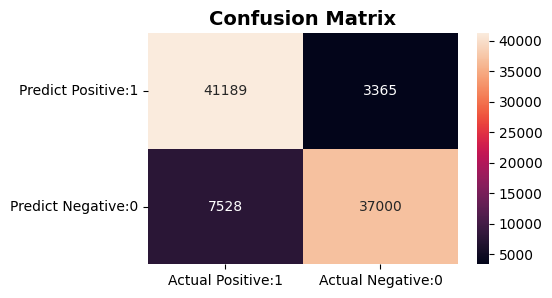

In [216]:
y_pred_test = model.predict(X_test)

print("Classification Report of Test Dataset\n")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
TN, FP, FN, TP = cm.ravel()

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sb.heatmap(cm_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

The created model has an <b>accuracy score of 0.88</b>, indicating the number of accurate predictions relative to the total number of predictions.

In [217]:
accuracy_score_s = (TP + TN) / float(TP + TN + FP + FN)   # OR accuracy_score(y_test_smore, y_pred_test)
print(f'Accuracy score: {round(accuracy_score_s, 2)}')

Accuracy score: 0.88


It has a <b>precision score of 0.92</b>, representing the number of positive predictions that are accurate compared to the total number of predicted positives.

In [218]:
precision_score_s = TP / float(TP + FP)   # OR precision_score(y_test_smore, y_pred_test)
print(f'Precision score: {round(precision_score_s, 2)}')

Precision score: 0.92


Its <b>recall score is 0.83</b>, indicating the proportion of actual positive cases that are correctly identified by the model out of all positive cases of heart disease.

In [219]:
recall_score_s = TP / float(TP + FN)  # OR recall_score(y_test_smore, y_pred_test)
print(f'Recall score: {round(recall_score_s, 2)}')

Recall score: 0.83


The ROC (Receiver Operating Characteristics) curve shown below is well-balanced, with an __AUC (Area Under the Curve) score of 0.96__, indicating a good level of distinction between the model's ability to predict true positive and false positive cases of heart disease. A curve that is situated more towards the top-left corner shows a larger area under it, resulting in a higher ROC AUC score. A perfect classifier would have an AUC of 1.

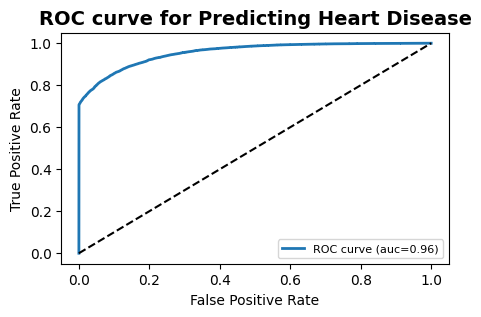

In [220]:
y_prob_test = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

auc = round(roc_auc_score(y_test, y_prob_test), 2)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve (auc=" + str(auc) + ")")
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Predicting Heart Disease', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Based from the results of evaluation metrics mentioned above, we can conclude that the model performs well in predicting heart disease.

### Making Test Prediction

We will evaluate our model by utilizing it to estimate the likelihood of a patient developing heart disease based on the patient's record provided below.

In [228]:
from enum import Enum

class Feature(Enum):

    BMI = 0
    PhysicalHealth = 1
    MentalHealth = 2
    SleepTime = 3
    Smoking = 4
    AlcoholDrinking = 5
    Stroke = 6
    DifficultyWalking = 7
    Sex = 8
    PhysicalActivity = 9
    Asthma = 10
    KidneyDisease = 11
    SkinCancer = 12
    AgeCategory_18_24 = 13
    AgeCategory_25_29 = 14
    AgeCategory_30_34 = 15
    AgeCategory_35_39 = 16
    AgeCategory_40_44 = 17
    AgeCategory_45_49 = 18
    AgeCategory_50_54 = 19
    AgeCategory_55_59 = 20
    AgeCategory_60_64 = 21
    AgeCategory_65_69 = 22
    AgeCategory_70_74 = 23
    AgeCategory_75_79 = 24
    AgeCategory_80_older = 25
    Diabetic_No = 26
    DiabeticBorderline = 27
    Diabetic_Yes = 28
    DiabeticPregnancy= 29
    GenHealth_Excellent = 30
    GenHealth_Fair = 31
    GenHealth_Good = 32
    GenHealth_Poor = 33
    GenHealth_Very_Good = 34


def getPrediction(input_data):
    data_df = np.array(input_data).reshape(1,-1)
    data_scaled_df = scale.transform(data_df)
    return round(model.predict_proba(data_scaled_df)[0][1] * 100, 2)


def testPrediction(input_data):

    print("-----------------------------------------------------------")
    print("                   PATIENT'S RECORD                        ")
    print("-----------------------------------------------------------")
    for key, value in input_data.items():
        print(f"{key}: {value}")
    print("-----------------------------------------------------------")
    
    upd_input_data = [0] * (heart_disease_df_dummy.columns.size - 1)

    upd_input_data[Feature.BMI.value] = input_data['BMI']
    upd_input_data[Feature.SleepTime.value] = input_data['Sleep Time']
    upd_input_data[Feature.PhysicalHealth.value] = input_data['Physical Health']
    upd_input_data[Feature.MentalHealth.value] = input_data['Mental Health']

    upd_input_data[Feature.Sex.value] = 1 if input_data['Sex'].lower()  == 'male' else 0
    upd_input_data[Feature.AlcoholDrinking.value] = 1 if input_data['Alcohol Drinking'].lower() == 'yes' else 0
    upd_input_data[Feature.PhysicalActivity.value] = 1 if input_data['Physical Activity'].lower()  == 'yes' else 0
    upd_input_data[Feature.Smoking.value] = 1 if input_data['Smoking'].lower()  == 'yes' else 0
    upd_input_data[Feature.Stroke.value] = 1 if input_data['Stroke'].lower()  == 'yes' else 0
    upd_input_data[Feature.Asthma.value] = 1 if input_data['Asthma'].lower()  == 'yes' else 0
    upd_input_data[Feature.KidneyDisease.value] = 1 if input_data['Kidney Disease'].lower()  == 'yes' else 0
    upd_input_data[Feature.SkinCancer.value] = 1 if input_data['Skin Cancer'].lower()  == 'yes' else 0
    upd_input_data[Feature.DifficultyWalking.value] = 1 if input_data['Difficulty Walking'].lower()  == 'yes' else 0

    age = input_data['Age']
    if 18 >= age <= 24:
        upd_input_data[Feature.AgeCategory_18_24.value] = 1
    elif 25 >= age <= 29:
        upd_input_data[Feature.AgeCategory_25_29.value] = 1
    elif 30 >= age <= 34:
        upd_input_data[Feature.AgeCategory_30_34.value] = 1
    elif 35 >= age <= 39:
        upd_input_data[Feature.AgeCategory_35_39.value] = 1
    elif 40 >= age <= 44:
        upd_input_data[Feature.AgeCategory_40_44.value] = 1
    elif 45 >= age <= 49:
        upd_input_data[Feature.AgeCategory_45_49.value] = 1
    elif 50 >= age <= 54:
        upd_input_data[Feature.AgeCategory_50_54.value] = 1
    elif 55 >= age <= 59:
        upd_input_data[Feature.AgeCategory_55_59.value] = 1
    elif 60 >= age <= 64:
        upd_input_data[Feature.AgeCategory_60_64.value] = 1
    elif 65 >= age <= 69:
        upd_input_data[Feature.AgeCategory_65_69.value] = 1
    elif 70 >= age <= 74:
        upd_input_data[Feature.AgeCategory_70_74.value] = 1
    elif 75 >= age <= 79:
        upd_input_data[Feature.AgeCategory_75_79.value] = 1
    elif age >= 80:
        upd_input_data[Feature.AgeCategory_80_older.value] = 1

    diabetic = input_data['Diabetic'].lower()
    if diabetic  == 'yes':
        upd_input_data[Feature.Diabetic_Yes.value] = 1
    elif diabetic  == 'no':
        upd_input_data[Feature.Diabetic_No.value] = 1
    elif diabetic.endswith("borderline"):
        upd_input_data[Feature.DiabeticBorderline.value] = 1
    elif diabetic.endswith("during pregnancy"):
        upd_input_data[Feature.DiabeticPregnancy.value] = 1

    general_health = input_data['General Health'].lower()
    if general_health == 'poor':
        upd_input_data[Feature.GenHealth_Poor.value] = 1
    elif general_health == 'fair':
        upd_input_data[Feature.GenHealth_Fair.value] = 1
    elif general_health == 'good':
        upd_input_data[Feature.GenHealth_Good.value] = 1
    elif general_health == 'very good':
        upd_input_data[Feature.GenHealth_Very_Good.value] = 1
    elif general_health == 'excellent':
        upd_input_data[Feature.GenHealth_Excellent.value] = 1

    prediction = getPrediction(upd_input_data)
    print(f"\nThe probability of {input_data['Name']} developing heart disease is {prediction}%")


__Test data #1__

In [229]:
input_data = {
    'Name' : 'Gino Cruz',
    'Sex' : 'Male',
    'Age' : 25,
    'BMI' : 21.6,
    'Smoking' : 'Yes',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'No',
    'Asthma' : 'No',
    'Kidney Disease' : 'No',
    'Skin Cancer' : 'No',
    'Difficulty Walking' : 'No',
    'Physical Activity' : 'Yes',
    'Physical Health' : 5,
    'Mental Health' : 10,
    'Sleep Time' : 7,
    'General Health' : 'Good'
} 

testPrediction(input_data)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Gino Cruz
Sex: Male
Age: 25
BMI: 21.6
Smoking: Yes
Alcohol Drinking: No
Stroke: No
Diabetic: No
Asthma: No
Kidney Disease: No
Skin Cancer: No
Difficulty Walking: No
Physical Activity: Yes
Physical Health: 5
Mental Health: 10
Sleep Time: 7
General Health: Good
-----------------------------------------------------------

The probability of Gino Cruz developing heart disease is 1.7%


__Test data #2__

In [246]:
input_data = {
    'Name' : 'Nicole Santos',
    'Sex' : 'Female',
    'Age' : 70,
    'BMI' : 35.06,
    'Smoking' : 'No',
    'Alcohol Drinking' : 'Yes',
    'Stroke' : 'Yes',
    'Diabetic' : 'Yes, during pregnancy',
    'Asthma' : 'No',
    'Kidney Disease' : 'No',
    'Skin Cancer' : 'No',
    'Difficulty Walking' : 'No',
    'Physical Activity' : 'Yes',
    'Physical Health' : 30,
    'Mental Health' : 15,
    'Sleep Time' : 8,
    'General Health' : 'Poor'
}

testPrediction(input_data)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Nicole Santos
Sex: Female
Age: 70
BMI: 35.06
Smoking: No
Alcohol Drinking: Yes
Stroke: Yes
Diabetic: Yes, during pregnancy
Asthma: No
Kidney Disease: No
Skin Cancer: No
Difficulty Walking: No
Physical Activity: Yes
Physical Health: 30
Mental Health: 15
Sleep Time: 8
General Health: Poor
-----------------------------------------------------------

The probability of Nicole Santos developing heart disease is 20.27%


__Test data #3__

In [231]:
input_data = {
    'Name' : 'Alfred Gomez',
    'Sex' : 'Male',
    'Age' : 75,
    'BMI' : 35.07,
    'Smoking' : 'No',
    'Alcohol Drinking' : 'No',
    'Stroke' : 'No',
    'Diabetic' : 'Yes',
    'Asthma' : 'Yes',
    'Kidney Disease' : 'Yes',
    'Skin Cancer' : 'No',
    'Difficulty Walking' : 'Yes',
    'Physical Activity' : 'No',
    'Physical Health' : 25,
    'Mental Health' : 10,
    'Sleep Time' : 6,
    'General Health' : 'Poor'
}

testPrediction(input_data)

-----------------------------------------------------------
                   PATIENT'S RECORD                        
-----------------------------------------------------------
Name: Alfred Gomez
Sex: Male
Age: 75
BMI: 35.07
Smoking: No
Alcohol Drinking: No
Stroke: No
Diabetic: Yes
Asthma: Yes
Kidney Disease: Yes
Skin Cancer: No
Difficulty Walking: Yes
Physical Activity: No
Physical Health: 25
Mental Health: 10
Sleep Time: 6
General Health: Poor
-----------------------------------------------------------

The probability of Alfred Gomez developing heart disease is 71.15%


### Comparing Evaluation Metrics (with and without using SMOTE)

Generate a new model using the non-SMOTE dataset then assess the performance of this model.

Classification Report for Test Dataset

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     66770
           1       0.00      0.00      0.00      6794

    accuracy                           0.91     73564
   macro avg       0.45      0.50      0.48     73564
weighted avg       0.82      0.91      0.86     73564



Text(0.5, 1.0, 'Confusion Matrix')

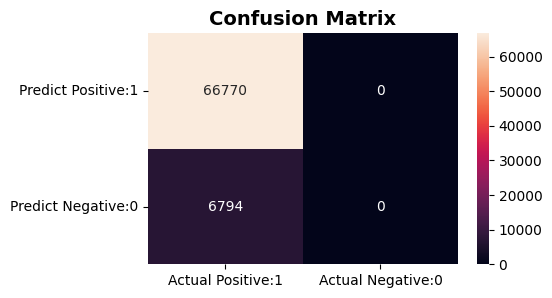

In [232]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

model_ns = LogisticRegressionCV(solver='lbfgs')
model_ns.fit(X_train_ns, y_train_ns)

y_pred_test_ns = model.predict(X_test_ns)

print("Classification Report for Test Dataset\n")
print(classification_report(y_test_ns, y_pred_test_ns))

cm_ns = confusion_matrix(y_test_ns, y_pred_test_ns)
cm_matrix_n = pd.DataFrame(data=cm_ns, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sb.heatmap(cm_matrix_n, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

Get the accuracy, precision, recall and auc scores for non-SMOTE model

In [233]:
accuracy_score_ns = accuracy_score(y_test_ns, y_pred_test_ns)
precision_score_ns = precision_score(y_test_ns, y_pred_test_ns)
recall_score_ns = recall_score(y_test_ns, y_pred_test_ns)

y_prob_test_ns = model.predict_proba(X_test_ns)[:,1]
auc_ns = round(roc_auc_score(y_test_ns, y_prob_test_ns), 4)

print(f'Accuracy score: {round(accuracy_score_ns, 2)}')
print(f'Precision score: {round(precision_score_ns, 2)}')
print(f'Recall score: {round(recall_score_ns, 2)}')
print(f'AUC score: {round(auc_ns, 2)}')

Accuracy score: 0.91
Precision score: 0.0
Recall score: 0.0
AUC score: 0.53


Plot in the graph the accuracy, precision, recall and auc scores to compare prediction performance of SMOTE and non-SMOTE models

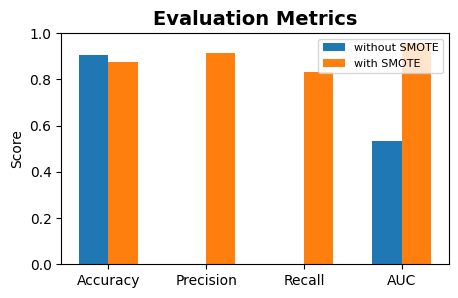

In [234]:
fig, (ax1) = plt.subplots(1)

labels = ['Accuracy', 'Precision', 'Recall', 'AUC']
ns_score = [accuracy_score_ns, precision_score_ns, recall_score_ns, auc_ns]
s_score = [accuracy_score_s, precision_score_s, recall_score_s, auc]

barWidth = 0.3
x = np.arange(len(ns_score))

ax1.bar(x - barWidth/2, ns_score, width=barWidth, label='without SMOTE')
ax1.bar(x + barWidth/2, s_score, width=barWidth, label='with SMOTE')

ax1.set_xticks(x, labels)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

plt.show()

__Explanation:__
The graph shows the non-SMOTE model has a considerably low precision score with 0.23, implying that only a small proportion of its positive predictions are accurate. This outcome can be attributed to the imbalanced distribution of the dataset among its classes, which severely skewed the model's precision. Additionally, all other non-SMOTE metrics display inferior scores. From this, it can be concluded that using SMOTE to balance the dataset has greatly improved the performance of our model.

### Conclusions

- The Logistic Regression algorithm with cross-validation has been used to train and test a model that can anticipate the probability of heart disease based on various key indicators. The model yields accuracy, precision, and recall scores of 0.88, 0.92 and 0.83, respectively, which are indicative of a sound classification performance.
- Using SMOTE to generate synthetic data has substantially improved the precision of the model. This technique is essential if the distribution of data among different classes is highly skewed. However, further analysis and testing is still necessary. To enhance the accuracy and precision of the model, it is preferable to have a larger quantity of real data about people with heart disease, as well as a more diversed racial category.
- The accuracy scores for the training and test datasets are similar when rounded up, with a score of 0.82. Therefore, there is no evidence of overfitting.
- With an ROC AUC value of 0.96, we can infer that our classifier performs very well in differentiate true positive against false positive cases of heart disease.

### References

1. https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
2. https://medium.com/geekculture/how-to-deal-with-class-imbalances-in-python-960908fe0425
3. https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492
4. https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5
5. https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
6. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

> AML-2203 Winter 2023 Mid-Term Project (Group 7)